# Understanding the IMDb Dataset

First, we'll need to set up our notebook to be able to process this data.

In [1]:
# Import necessary libraries and packages
import pandas as pd
import numpy as np
import sqlite3
import zipfile
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Extract IMDb SQL .db file
with zipfile.ZipFile('../../data/im.db.zip') as zipObj:
    # Extract all contents of .zip file into current directory
    zipObj.extractall(path='../../data/')
    
# Create connection to IMDb DB
con = sqlite3.connect('../../data/im.db')

Let's take a look at what this dataset actually *contains*, i.e. the names of the tables

In [3]:
pd.read_sql("""

SELECT *
FROM sqlite_master

""",con)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


For starters, let's take a look at the ```movie_basics``` and ```movie_ratings``` tables.

In [4]:
basics_query = """SELECT * FROM movie_basics"""

pd.read_sql(basics_query,con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


146,144 entries - that's a **lot** of movies!

We have a few columns with null values: ```original_title```, ```runtime_minutes```, and ```genres```. We'll have to figure out how to deal with those in due time, but first, let's get a closer look at what's actually contained in the table.

In [5]:
pd.read_sql(basics_query,con).head(10)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller"
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy"
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History"
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography


Since most of the movies in the dataset have the same `primary_title` and `original_title`, and because `primary_title` is often an English-translated title, we can probably drop `original_title` when we join these tables.

We also have a primary key: `movie_id`.

Okay, what about the table `movie_ratings`?

In [6]:
ratings_query = """SELECT * FROM movie_ratings"""

pd.read_sql(ratings_query,con).head(10)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
5,tt1069246,6.2,326
6,tt1094666,7.0,1613
7,tt1130982,6.4,571
8,tt1156528,7.2,265
9,tt1161457,4.2,148


That table is easy enough to read, but it only gives us **alphanumeric values** to identify what movie is associated with a given row's `averagerating` and `numvotes`. We will address that when we join the tables.

Let's take a more bird's-eye view of the `movie_ratings` table using `.info()`.

In [7]:
pd.read_sql(ratings_query,con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


No null values in any of the three columns! But `movie_ratings`, with 73,856 rows, has only *half* as many entries as `movie_basics` - that means there are a lot of entries in `movie_basics` without an associated rating.

The two tables have `movie_id` in common, so we'll join them on that column.

Which column should we investigate first in order to get a sense of what movies (and what kinds of movies) are popular: `averagerating` or `numvotes`?

The values in the column `averagerating` provide us an idea of what *scores* IMDb users have assigned a movie (i.e. users' *evaluations* of a movie's quality), but `numvotes` tells us *how many* IMDb users have rated the movie, which likely gives us a better idea of a movie's **reach**. Let's order our data by `numvotes` to start.

In [8]:
# Creating new query: Joining movie_basics and
# movie_ratings, ordering by total # of ratings

votes_query = """
    SELECT
        -- Importing columns from movie_basics
        mb.primary_title AS "Title",
        mb.start_year AS "Release Year",
        -- Importing columns from movie_ratings
        mr.averagerating AS "Avg. Rating",
        mr.numvotes AS "# of Ratings"
    FROM
        movie_basics AS mb
        JOIN movie_ratings AS mr
            ON mb.movie_id = mr.movie_id
    WHERE
        -- Looking at movies only from 2010-2019 (most recent
        -- year in dataset) for last ten years' of data
        mb.start_year >= 2010
    ORDER BY
        mr.numvotes DESC
"""

# Creating new dataframe based on votes_query
sample_df = pd.read_sql(votes_query,con)

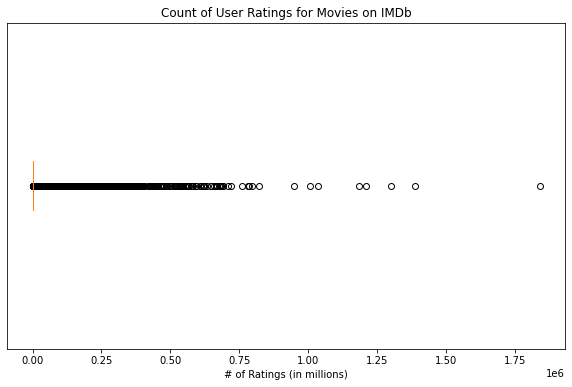

In [9]:
# Assigning the values from '# of Ratings' column to
# new variable ratings_counts
ratings_counts = sample_df['# of Ratings']

# Plotting ratings_counts as a boxplot
fig, ax = plt.subplots(figsize=(10,6))

plt.tick_params(
    axis='y',
    which='both',
    left=False,
    labelleft=False)

ax.boxplot(ratings_counts, vert=False)
ax.set_title("Count of User Ratings for Movies on IMDb")
ax.set_xlabel("# of Ratings (in millions)");

That is a very skewed boxplot - it's hard to even make any sense of it. Let's look at the descriptive statistics for the `# of Ratings` column.

In [10]:
ratings_counts.describe().apply(lambda x: format(x, 'f'))

count      73856.000000
mean        3523.662167
std        30294.022971
min            5.000000
25%           14.000000
50%           49.000000
75%          282.000000
max      1841066.000000
Name: # of Ratings, dtype: object

(The function to convert the output of `ratings_counts.describe()` from scientific notation to the above notation was provided by [Ash Upadhyay](https://stackoverflow.com/posts/47207283/revisions).)

Wow... not only is our ```mean``` well above the ```50%``` value (the median), but it's **more than ten times larger** than the ```75%``` value! The most popular movie on the site is represented by `max` and has 1,841,066 ratings. 

From a business perspective, it probably doesn't make a lot of sense to home in on movies with low numbers of user ratings. In the SQL query below, we order by `numvotes`/`# of Ratings` once again, but we limit our output to 500. This yields a dataframe with information about the 500 movies with the greatest number of user ratings - not only is it more manageable than working with thousands of records, we're also only working movies that are verifiably **popular** with IMDb users.

In [11]:
imdb_df_sample = pd.read_sql("""
    SELECT
        -- Importing columns from movie_basics
        mb.primary_title AS "Title",
        mb.start_year AS "Release Year",
        mb.genres AS "genres",
        mb.runtime_minutes AS "Runtime",
        -- Importing columns from movie_ratings
        mr.averagerating AS "Avg. Rating",
        mr.numvotes AS "# of Ratings"
    FROM
        movie_basics AS mb
        JOIN movie_ratings AS mr
            ON mb.movie_id = mr.movie_id
    WHERE
        -- Looking at movies only with more than 100,000
        -- user ratings
        mr.numvotes >= 100000 AND
        -- Looking at movies only from 2010-2019 (most recent
        -- year in dataset)
        mb.start_year >= 2010
    ORDER BY
        mr.numvotes DESC
    LIMIT 500
""",con)

print(imdb_df_sample.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         500 non-null    object 
 1   Release Year  500 non-null    int64  
 2   genres        500 non-null    object 
 3   Runtime       500 non-null    float64
 4   Avg. Rating   500 non-null    float64
 5   # of Ratings  500 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 23.6+ KB
None


Okay, so we've got a sample of 500 movies, each of which has been rated *at least* 100,000 times by IMDb users (though we cannot guarantee these are all unique users.) This sample represents the 500 movies on the site with the greatest number of user ratings.

In [12]:
# Database column 'genres' gives us multiple genres separated
# by commas -- using split() to create a LIST of genres
imdb_df_sample['genres'] = imdb_df_sample['genres'].str.split(',')

# Let's look at the 10 movies with the highest # of user ratings
imdb_df_sample.head(10)

,Title,Release Year,genres,Runtime,Avg. Rating,# of Ratings
0,Inception,2010,"[Action, Adventure, Sci-Fi]",148.0,8.8,1841066
1,The Dark Knight Rises,2012,"[Action, Thriller]",164.0,8.4,1387769
2,Interstellar,2014,"[Adventure, Drama, Sci-Fi]",169.0,8.6,1299334
3,Django Unchained,2012,"[Drama, Western]",165.0,8.4,1211405
4,The Avengers,2012,"[Action, Adventure, Sci-Fi]",143.0,8.1,1183655
5,The Wolf of Wall Street,2013,"[Biography, Crime, Drama]",180.0,8.2,1035358
6,Shutter Island,2010,"[Mystery, Thriller]",138.0,8.1,1005960
7,Guardians of the Galaxy,2014,"[Action, Adventure, Comedy]",121.0,8.1,948394
8,Deadpool,2016,"[Action, Adventure, Comedy]",108.0,8.0,820847
9,The Hunger Games,2012,"[Action, Adventure, Sci-Fi]",142.0,7.2,795227


It looks like we have a pretty wide range of runtimes, and several of the movies with the highest average ratings on the site clock in at **over 2.5 hours!** Given the lack of correlation between a movie's runtime and its performance with critics we observed in the RottenTomatoes data, we can safely drop ```runtime_minutes``` / ```Runtime``` and focus on the other columns instead.

In [13]:
imdb_df_sample.drop(columns=['Runtime'], inplace=True)

Let's get a closer look at the `genres` column so that we can figure out what genres occur most frequently in this set of movies with 100,000+ user ratings.

In [14]:
imdb_df_sample['genres']

0      [Action, Adventure, Sci-Fi]
1               [Action, Thriller]
2       [Adventure, Drama, Sci-Fi]
3                 [Drama, Western]
4      [Action, Adventure, Sci-Fi]
                  ...             
495               [Drama, Romance]
496          [Drama, Mystery, War]
497              [Crime, Thriller]
498                [Comedy, Drama]
499     [Drama, Mystery, Thriller]
Name: genres, Length: 500, dtype: object

Looks like the ```genres``` column has a *list* of genres for each entry. We're going to need to split those lists up in order to get accurate value counts for each genre. (Credit for this function goes to [Max Hilsdorf](https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173).)

In [15]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

# Top ten most frequently occurring genres
top_genres = to_1D(imdb_df_sample['genres']).value_counts().head(10)

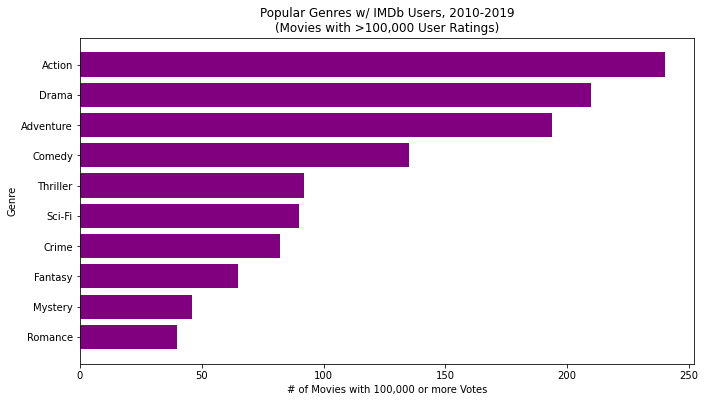

In [16]:
# Plotting top ten genres
genres_fig, ax = plt.subplots(figsize = (11, 6))

ax.invert_yaxis()
ax.barh(y=top_genres.index,
       width=top_genres,
       color='purple',)
ax.set_title("""Popular Genres w/ IMDb Users, 2010-2019
(Movies with >100,000 User Ratings)""")
ax.set_xlabel("# of Movies with 100,000 or more Votes")
ax.set_ylabel("Genre");

Interesting. It looks like `Action` is the most popular genre, with nearly **half** of the 500 most-frequently-rated movies containing `Action` in their list of genres!

`Drama` and `Adventure` sit in the second and third place slots, respectively, with `Comedy` in fourth place; this lends credence to the interpretation that `Drama` films reach a wider swath of moviegoers, though `Comedy` remains very popular. `Thriller` movies round out the top five.

If we subset our data so that we're only looking at the most recent five years' worth of data, do these trends change at all? Let's find out.

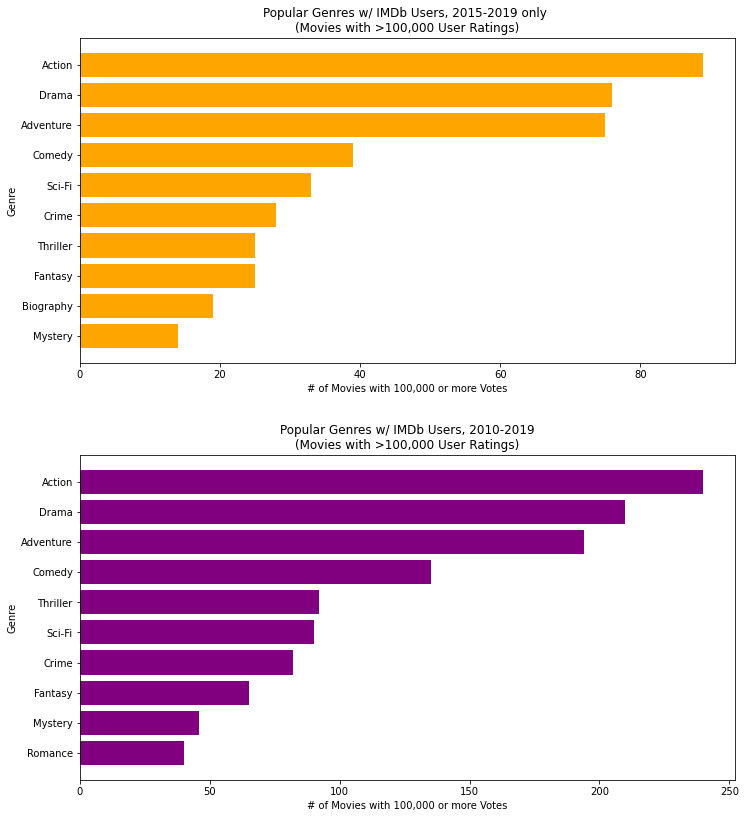

In [22]:
# Obtaining a dataframe of only movies released 2015-2019
late_decade_df = imdb_df_sample[imdb_df_sample['Release Year'] >= 2015]

# Creating another list of top ten genres
genres2 = to_1D(late_decade_df['genres']).value_counts().head(10)

# Creating a second graph
genres_fig2, ax = plt.subplots(2, figsize = (11, 12))

ax[0].invert_yaxis()
ax[0].barh(y=genres2.index,
       width=genres2,
       color='orange')
ax[0].set_title("""Popular Genres w/ IMDb Users, 2015-2019 only 
(Movies with >100,000 User Ratings)""")
ax[0].set_xlabel("# of Movies with 100,000 or more Votes")
ax[0].set_ylabel("Genre")

ax[1].invert_yaxis()
ax[1].barh(y=top_genres.index,
       width=top_genres,
       color='purple',)
ax[1].set_title("""Popular Genres w/ IMDb Users, 2010-2019
(Movies with >100,000 User Ratings)""")
ax[1].set_xlabel("# of Movies with 100,000 or more Votes")
ax[1].set_ylabel("Genre")
genres_fig2.tight_layout(pad=3.0)
genres_fig2.savefig('../../images/Popular Genres with IMDb Users.jpg',
            transparent=False,bbox_inches="tight");

These graphs are pretty comparable, both in their shapes and in their distributions of genres. We can observe an uptick in the popularity of `Sci-Fi` in the latter half of the 2010s, slightly eclipsing the popularity of `Thriller` movies (`Thriller` drops to 8<sup>th</sup> place, below `Crime` and `Fantasy`). The differences between the graphs are not profound or significant, but we can definitely comment on the increased profile of `Sci-Fi` films in the last five years' of data.

# Working code -- currently not intended for use in final notebook

In [18]:
# Trying to figure out what to do with directors
# and persons
pd.read_sql("""
    SELECT
        prsn.primary_name AS "Name",
        COUNT() AS "Number of Movies"
    FROM
        persons AS prsn
        JOIN directors AS drs
            on prsn.person_id = drs.person_id
    GROUP BY
        "Name"
    ORDER BY
        "Number of Movies" DESC
    LIMIT 200
""",con);